In [1]:
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score

## Read data

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_data = datasets.MNIST(root='./dataset/mnist', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./dataset/mnist', train=False, transform=transform, download=True)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 40958023.29it/s]


Extracting ./dataset/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50705606.46it/s]

Extracting ./dataset/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8757685.12it/s]


Extracting ./dataset/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9487315.12it/s]

Extracting ./dataset/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/mnist/MNIST/raw



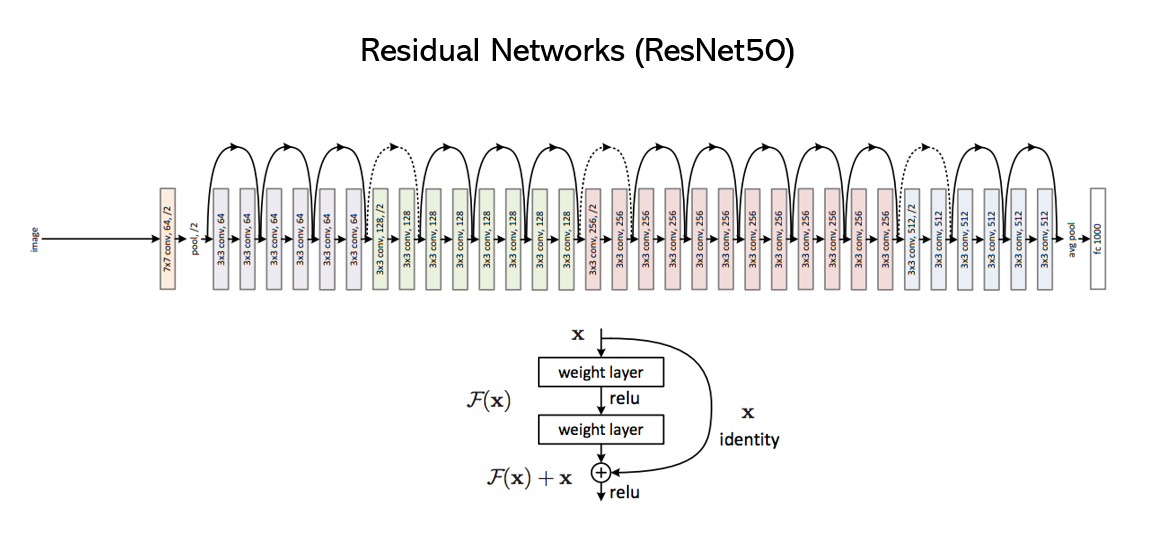

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.channel = channel
        
        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out) + x
        out = self.relu(out)
        
        return x

In [4]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.resblock1 = ResidualBlock(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.resblock2 = ResidualBlock(32)
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.out = nn.Linear(512, 10)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.maxpool2d(self.relu(self.conv1(x)))
        x = self.resblock1(x)
        x = self.maxpool2d(self.relu(self.conv2(x)))
        out = x.view(x.shape[0], -1)
        out = self.out(out)
        
        return out
        

In [8]:
def eval(dataloader, model, criterion, epoch, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    sum_loss = 0
    
    for batch in tqdm(dataloader):
        img, labels = batch
        img, labels = img.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(img)
            loss = criterion(logits, labels)
            sum_loss += loss.cpu().item()
            
        pred = torch.argmax(logits, dim=1)
        predicted_labels.extend(pred.cpu())
        true_labels.extend(labels.cpu())
    
    print(f'Eval loss epoch {epoch + 1}={sum_loss / len(dataloader)}')
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')
    print(f'Eval Accuracy: {accuracy} \n F1-macro {f1_macro}')

def train(train_dataloader,
          test_dataloader,
          num_epochs,
          criterion,
          optimizer,
          device=None,
          scheduler=None,
          save_epoch_checkpoint=False,
          output_dir=None
         ):

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        criterion.to(device)
        
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            predicted_labels = []
            true_labels = []
            for batch in tqdm(train_dataloader, desc=f'epoch {epoch + 1} / {num_epochs}'):
                optimizer.zero_grad()
                
                img, label = batch
                img, label = img.to(device), label.to(device)
                
                logits = model(img)
                loss = criterion(logits, label)
                epoch_loss += loss.cpu().item()
                pred = logits.argmax(dim=1).cpu()
                predicted_labels.extend(pred)
                true_labels.extend(label.cpu())
                
                loss.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                    
            print(f'epoch {epoch + 1} loss={epoch_loss / len(train_dataloader)}')
            accuracy = accuracy_score(true_labels, predicted_labels)
            f1_macro = f1_score(true_labels, predicted_labels, average='macro')
            print(f'Accuracy on train: {accuracy} \n F1-macro {f1_macro}')
            eval(test_dataloader, model, criterion, epoch=epoch, device=device)
            

In [9]:
model = SimpleResNet()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_dataloader), epochs=15)

In [10]:
train(train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      num_epochs=10,
      criterion=criterion,
      optimizer=optimizer,
      scheduler=scheduler
     )

epoch 1 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 1 loss=0.9821266293416421
Accuracy on train: 0.7753833333333333 
 F1-macro 0.7757611243696743


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 1=0.27924071657657623
Eval Accuracy: 0.9196 
 F1-macro 0.9185347084282428


epoch 2 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 2 loss=0.20172854049640399
Accuracy on train: 0.94045 
 F1-macro 0.9399444573075298


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 2=0.11998887199424207
Eval Accuracy: 0.9639 
 F1-macro 0.9637389497772814


epoch 3 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 3 loss=0.09801816775690143
Accuracy on train: 0.9705666666666667 
 F1-macro 0.9703663111870343


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 3=0.06667516346392222
Eval Accuracy: 0.9778 
 F1-macro 0.9777119310828066


epoch 4 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 4 loss=0.06598939430884396
Accuracy on train: 0.9795666666666667 
 F1-macro 0.9794242307712263


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 4=0.045749026456603316
Eval Accuracy: 0.9857 
 F1-macro 0.9855922681623239


epoch 5 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 5 loss=0.049921184500609526
Accuracy on train: 0.9841333333333333 
 F1-macro 0.98402639517136


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 5=0.04076093316674814
Eval Accuracy: 0.9858 
 F1-macro 0.9857145375547656


epoch 6 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 6 loss=0.038720238068360294
Accuracy on train: 0.98765 
 F1-macro 0.9875641478042478


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 6=0.03226650882231188
Eval Accuracy: 0.9888 
 F1-macro 0.988699986422418


epoch 7 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 7 loss=0.030670332879087072
Accuracy on train: 0.9901666666666666 
 F1-macro 0.9901133524441551


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 7=0.031343786286524844
Eval Accuracy: 0.9887 
 F1-macro 0.9885894435198465


epoch 8 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 8 loss=0.024186627898597605
Accuracy on train: 0.9926833333333334 
 F1-macro 0.992656078837322


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 8=0.025872232310233084
Eval Accuracy: 0.9907 
 F1-macro 0.9906154911602693


epoch 9 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 9 loss=0.01921379631343055
Accuracy on train: 0.9941166666666666 
 F1-macro 0.9940965857578725


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 9=0.02887679843881924
Eval Accuracy: 0.9903 
 F1-macro 0.9902180602785347


epoch 10 / 10:   0%|          | 0/3750 [00:00<?, ?it/s]

epoch 10 loss=0.014636658523209311
Accuracy on train: 0.99545 
 F1-macro 0.995441900431096


  0%|          | 0/625 [00:00<?, ?it/s]

Eval loss epoch 10=0.025805574260927278
Eval Accuracy: 0.9921 
 F1-macro 0.9920160211451915
